In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.stats as stats
import seaborn as sns
import pingouin as pg
from sklearn.linear_model import LinearRegression
import random
import warnings
import statsmodels.formula.api as smf
from matplotlib.lines import Line2D
import statsmodels.api as sm
from statsmodels.stats.sandwich_covariance import cov_cluster
from statsmodels.stats.anova import anova_lm

/var/folders/xp/jv15pxc52y1dwz_14_0kyy740000gp/T/ipykernel_63437/1401463414.py:20: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  arrow1 = mpatches.FancyArrow(200, 1.075, 190, 0, width=0.01, color='#051094', edgecolor='lightgray', head_width=.015, head_length=20, length_includes_head = True)
/var/folders/xp/jv15pxc52y1dwz_14_0kyy740000gp/T/ipykernel_63437/1401463414.py:21: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  arrow2 = mpatches.FancyArrow(200,1, -90, 0, width=0.01, color='#C80815', edgecolor='lightgray', head_width=.015, head_length=20, length_includes_head = True)


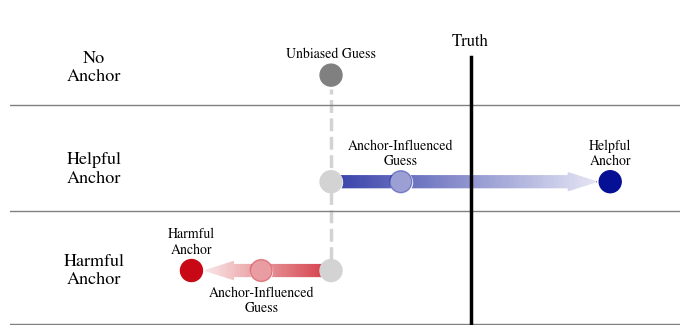

In [2]:
fig, ax = plt.subplots(figsize=(7, 3.45))

colors = ['grey','lightgrey','#051094','#051094','#C80815', '#C80815', 'lightgrey']
values = [200, 200, 250, 400, 100, 150, 200]
ys = [1.165, 1.075,1.075,1.075,1,1,1]
alphas = [1, 1, .4, 1, 1, .4, 1]


ax.axvline(x=200, ymin = 0.15, ymax=0.75, color='lightgray', linestyle='--', linewidth=2.5)

# Gradient Arrows
def create_gradient(x_1, x_2, y, n, direction):
    delta_x = (x_2 - x_1) / n   
    for i in range(n):
        if direction:
            alpha_val = .2 + (i/n * .7)
        else:
            alpha_val = .9 - (i/n * .7)
        ax.add_patch(mpatches.Rectangle((x_1+delta_x*i, y), delta_x, .05, fill=True, lw=0, color='w', alpha=alpha_val))
arrow1 = mpatches.FancyArrow(200, 1.075, 190, 0, width=0.01, color='#051094', edgecolor='lightgray', head_width=.015, head_length=20, length_includes_head = True)
arrow2 = mpatches.FancyArrow(200,1, -90, 0, width=0.01, color='#C80815', edgecolor='lightgray', head_width=.015, head_length=20, length_includes_head = True)
ax.add_patch(arrow1)
ax.add_patch(arrow2)
create_gradient(200, 390, 1.05, 100, True)
create_gradient(110, 200, .975, 80, False)

scatter = ax.scatter(values, ys, s=250, c='white', marker='o')
scatter = ax.scatter(values, ys, s=250, c=colors, marker='o', alpha = alphas)



labels = ["Unbiased Guess",
        "Anchor-Influenced\nGuess", 
        "Helpful\nAnchor",
        "Harmful\nAnchor", 
        "Anchor-Influenced\nGuess"]

xs = [200, 250, 400, 100, 150]
ys = [1.165, 1.075,1.075,1,1]
for i, txt in enumerate(labels):
    if i == 4:
        m = -30
    else:
        m = 12 # use cambria font
    ax.annotate(txt, (xs[i], ys[i]), textcoords="offset points", xytext=(0,m), ha='center', fontsize=10, fontname='times')

ax.annotate("Truth", (300, 1.19), textcoords="offset points", xytext=(0,0), ha='center', fontsize=12, weight='bold', fontname='times')
ax.annotate("No\nAnchor", (30, 1.16), textcoords="offset points", xytext=(0,0), ha='center', fontsize=13, weight='bold', fontname='times')
ax.annotate("Helpful\nAnchor", (30, 1.08), textcoords="offset points", xytext=(0,-5), ha='center', fontsize=13, weight='bold', fontname='times')
ax.annotate("Harmful\nAnchor", (30, 1), textcoords="offset points", xytext=(0,-10), ha='center', fontsize=13, weight='bold', fontname='times')


ax.axhline(y=1.14, color='gray', linestyle='-', linewidth=1)
ax.axhline(y=1.05, color='gray', linestyle='-', linewidth=1)
ax.axhline(y=0.955, color='gray', linestyle='-', linewidth=1)


ax.set_ylim(0.954, 1.22)
ax.axvline(x=300, ymin = 0, ymax=0.85, color='k', linestyle='-', linewidth=2.5)
ax.set_xlim(-30, 450)
ax.set_xticks([])
ax.get_yaxis().set_visible(False)
for spine in ax.spines.values():
    spine.set_visible(False)
plt.tight_layout()
plt.savefig('Figures/Figure-1_Types-of-Anchors.png', dpi=300)
plt.show()


In [11]:
# Read in data and create composite variables
df = pd.read_csv('ci_cb_2023-06-26.csv')

df['Anchor'] = np.where(df['Condition'] == 'Low', 118, 353)
df['Mag_Rev1'] = abs(df['response_2'] - df['response_1'])
df['Mag_Rev2'] = abs(df['response_3'] - df['response_2'])
df['Mag_Rev'] = abs(df['response_3'] - df['response_1'])
df['Initial_Error'] = abs(df['response_1'] - df['true_answer'])
df['Second_Error'] = abs(df['response_2'] - df['true_answer'])
df['Final_Error'] = abs(df['response_3'] - df['true_answer'])
df['Dist_Anchor_1'] = abs(df['response_1'] - df['Anchor'])
df['Dist_Anchor_2'] = abs(df['response_2'] - df['Anchor'])
df['Dist_Anchor_3'] = abs(df['response_3'] - df['Anchor'])
df['Difference_Initial_Anchor'] = df['response_1'] - df['Anchor']
df['Difference_Initial_Truth'] = df['response_1'] - 246
df['Matched'] = np.where(df['Difference_Initial_Anchor'] * df['Difference_Initial_Truth'] > 0, 1, 0)
df['Change_accuracy'] = df['Initial_Error'] - df['Final_Error']

# Load data from previous experiment which asked this question without anchoring
df_old = pd.read_csv('pnas.1615978114.sd01.csv')
df_old = df_old.loc[(df_old.task == '4d')]
df_old = df_old.dropna(subset=['response_1'])

/var/folders/xp/jv15pxc52y1dwz_14_0kyy740000gp/T/ipykernel_63437/1140659978.py:2: FutureWarning: The provided callable <function median at 0x10d4d4ae0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  df_temp_con = df_con.groupby('group').agg({'response_1': np.median,  'response_2': np.median, 'response_3': np.median, 'Initial_Error': np.median,
/var/folders/xp/jv15pxc52y1dwz_14_0kyy740000gp/T/ipykernel_63437/1140659978.py:14: FutureWarning: The provided callable <function median at 0x10d4d4ae0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  df_temp = df_temp.groupby('group').agg({'response_1': np.median,  'response_2': np.median, 'response_3': np.median, 'Initial_Error': np.median,


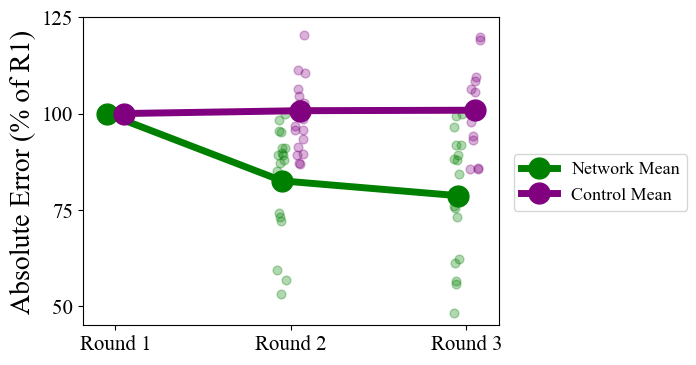

In [12]:
df_con = df.loc[df.Net_type == 'Control'].dropna(subset=['response_1', 'response_2', 'response_3'])
df_temp_con = df_con.groupby('group').agg({'response_1': np.median,  'response_2': np.median, 'response_3': np.median, 'Initial_Error': np.median,
                                            'Second_Error': np.median, 'Final_Error': np.median, 'Anchor': 'first', 'Condition': 'first'})

df_temp_con['Final_Error'] = df_temp_con['Final_Error'] / df_temp_con['Initial_Error'] * 100
df_temp_con['Second_Error'] = df_temp_con['Second_Error'] / df_temp_con['Initial_Error'] * 100
df_temp_con['Initial_Error'] = 100


df_con = df_temp_con


df_temp = df.loc[df.Net_type == 'Network'].dropna(subset=['response_1', 'response_2', 'response_3'])
df_temp = df_temp.groupby('group').agg({'response_1': np.median,  'response_2': np.median, 'response_3': np.median, 'Initial_Error': np.median,
                                              'Second_Error': np.median, 'Final_Error': np.median, 'Anchor': 'first', 'Condition': 'first'})
df_temp['Final_Error'] = df_temp['Final_Error'] / df_temp['Initial_Error'] * 100
df_temp['Second_Error'] = df_temp['Second_Error'] / df_temp['Initial_Error'] * 100
df_temp['Initial_Error'] = 100

df_net = df_temp

fig, axs = plt.subplots(1, 1, figsize=(7, 4))

axs.plot([-0.05, .95, 1.95],[df_net[i].mean() for i in ['Initial_Error', 'Second_Error', 'Final_Error']], '-o', color='green', ms = 15, lw=5, label='Network Mean')
axs.plot([0.05, 1.05, 2.05],[df_con[i].mean() for i in ['Initial_Error', 'Second_Error', 'Final_Error']], '-o', color='purple', ms = 15, lw=5, label='Control Mean')


jitter = 0.03

# Network group points
axs.scatter([-0.05 + np.random.uniform(-jitter, jitter) for _ in range(len(df_net))], df_net['Initial_Error'],
            s=40, alpha=0.3, color='green')
axs.scatter([0.95 + np.random.uniform(-jitter, jitter) for _ in range(len(df_net))], df_net['Second_Error'],
            s=40, alpha=0.3, color='green')
axs.scatter([1.95 + np.random.uniform(-jitter, jitter) for _ in range(len(df_net))], df_net['Final_Error'],
            s=40, alpha=0.3, color='green')

# Control group points
axs.scatter([0.05 + np.random.uniform(-jitter, jitter) for _ in range(len(df_con))], df_con['Initial_Error'],
            s=40, alpha=0.3, color='purple')
axs.scatter([1.05 + np.random.uniform(-jitter, jitter) for _ in range(len(df_con))], df_con['Second_Error'],
            s=40, alpha=0.3, color='purple')
axs.scatter([2.05 + np.random.uniform(-jitter, jitter) for _ in range(len(df_con))], df_con['Final_Error'],
            s=40, alpha=0.3, color='purple')

axs.set_xticks([0, 1, 2], ['Round 1', 'Round 2', 'Round 3'], fontsize=15, fontfamily='Times New Roman')
axs.set_ylabel('Absolute Error (% of R1)', fontsize=20, fontfamily='Times New Roman')
axs.set_ylim(45, 125)
axs.set_yticks([50, 75, 100, 125], ['50', '75', '100', '125'], fontsize=15, fontfamily='Times New Roman')
fig.legend(fontsize=20,loc='center right', prop={'family': 'Times New Roman', 'size': 13})
plt.subplots_adjust(right=0.72)
plt.savefig('Figures/Figure-3_Change-Error.png', dpi=300)
plt.show()



/var/folders/xp/jv15pxc52y1dwz_14_0kyy740000gp/T/ipykernel_63437/997411955.py:6: FutureWarning: The provided callable <function median at 0x10d4d4ae0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  df_temp = df_temp.groupby(['group','Matched']).agg({'Dist_Anchor_1': np.median,'Dist_Anchor_2': np.median,'Dist_Anchor_3': np.median})
/var/folders/xp/jv15pxc52y1dwz_14_0kyy740000gp/T/ipykernel_63437/997411955.py:31: FutureWarning: The provided callable <function median at 0x10d4d4ae0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  df_temp = df_temp.groupby(['group','Matched']).agg({'Dist_Anchor_1': np.median,'Dist_Anchor_2': np.median,'Dist_Anchor_3': np.median})


Median distance to anchor:
Helpful 146.0
Harmful 51.0
Individual level changes by group:
Networks
Means: -14.125 20.175
STD Errors: 2.4725965203873392 3.4121758569785596
Helpful WilcoxonResult(statistic=19.0, pvalue=0.0005855560302734375)
Harmful WilcoxonResult(statistic=0.0, pvalue=0.00019540793740897318)
Controls
Means: -3.45 2.975
STD Errors: 2.669996550362447 1.7264343769442083
Helpful: WilcoxonResult(statistic=65.0, pvalue=0.37180364974669)
Harmful: WilcoxonResult(statistic=45.0, pvalue=0.23385151493679546)

Differences between conditions:
Helpful: -14.125 -3.45
MannwhitneyuResult(statistic=69.5, pvalue=0.0004340060463465756)
Harmful: 20.175 2.975
MannwhitneyuResult(statistic=305.5, pvalue=0.004389968439207104)


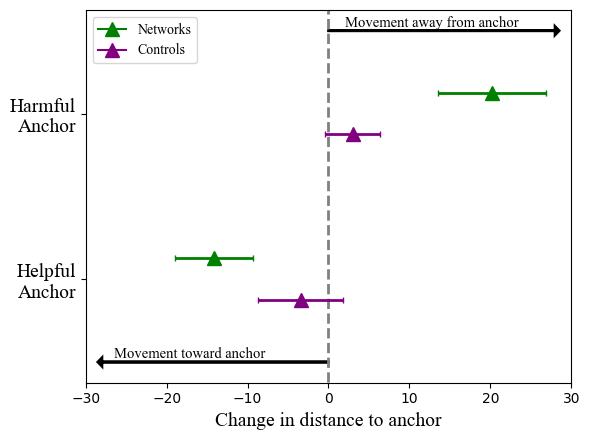

In [6]:
# Create a similar figure, except make it a single plot and insteaad of bars, plot points and 95% confidence intervals. Do this vertically
# Individual distance to the anchor
# Note for this analysis, we group participants both by group and by whether the anchor was toward or away from the truth (i.e., 'Matched')

df_temp = df.loc[df.Net_type == 'Network'].dropna(subset=['Matched', 'Dist_Anchor_1', 'Dist_Anchor_2', 'Dist_Anchor_3'])
df_temp = df_temp.groupby(['group','Matched']).agg({'Dist_Anchor_1': np.median,'Dist_Anchor_2': np.median,'Dist_Anchor_3': np.median})
df_temp['Change_in_Distance'] = df_temp['Dist_Anchor_3'] - df_temp['Dist_Anchor_1']
df_temp = df_temp.reset_index(level=['Matched'])

print('Median distance to anchor:') # For percentages, could do percentage of median distance to anchor
print('Helpful',df_temp.loc[df_temp.Matched == 1]['Dist_Anchor_1'].median())
print('Harmful',df_temp.loc[df_temp.Matched == 0]['Dist_Anchor_1'].median())

print('Individual level changes by group:')
print('Networks')
print('Means:',df_temp.loc[df_temp.Matched == 1]['Change_in_Distance'].mean(), df_temp.loc[df_temp.Matched == 0]['Change_in_Distance'].mean())
print('STD Errors:',df_temp.loc[df_temp.Matched == 1]['Change_in_Distance'].std() / np.sqrt(df_temp['Change_in_Distance'].count()),
      df_temp.loc[df_temp.Matched == 0]['Change_in_Distance'].std() / np.sqrt(df_temp['Change_in_Distance'].count()))

away, toward, away_cis, toward_cis = [], [], [], []
away.append(df_temp.loc[df_temp.Matched == 0]['Change_in_Distance'].mean())
toward.append(df_temp.loc[df_temp.Matched == 1]['Change_in_Distance'].mean())
away_cis.append(1.96*df_temp.loc[df_temp.Matched == 0]['Change_in_Distance'].std() / np.sqrt(df_temp['Change_in_Distance'].count()))
toward_cis.append(1.96*df_temp.loc[df_temp.Matched == 1]['Change_in_Distance'].std() / np.sqrt(df_temp['Change_in_Distance'].count()))
print('Helpful',stats.wilcoxon(df_temp.loc[df_temp['Matched'] == 1]['Change_in_Distance']))
print('Harmful',stats.wilcoxon(df_temp.loc[df_temp['Matched'] == 0]['Change_in_Distance']))
df_network = df_temp


df_temp = df.loc[df.Net_type == 'Control'].dropna(subset=['Matched', 'Dist_Anchor_1', 'Dist_Anchor_2', 'Dist_Anchor_3'])
df_temp = df_temp.groupby(['group','Matched']).agg({'Dist_Anchor_1': np.median,'Dist_Anchor_2': np.median,'Dist_Anchor_3': np.median})
df_temp['Change_in_Distance'] = df_temp['Dist_Anchor_3'] - df_temp['Dist_Anchor_1']

# Make matched into a column
df_temp = df_temp.reset_index(level=['Matched'])

print('Controls')
print('Means:',df_temp.loc[df_temp.Matched == 1]['Change_in_Distance'].mean(), df_temp.loc[df_temp.Matched == 0]['Change_in_Distance'].mean())
print('STD Errors:',df_temp.loc[df_temp.Matched == 1]['Change_in_Distance'].std() / np.sqrt(df_temp['Change_in_Distance'].count()),
      df_temp.loc[df_temp.Matched == 0]['Change_in_Distance'].std() / np.sqrt(df_temp['Change_in_Distance'].count()))

away.append(df_temp.loc[df_temp.Matched == 0]['Change_in_Distance'].mean())
toward.append(df_temp.loc[df_temp.Matched == 1]['Change_in_Distance'].mean())
away_cis.append(1.96*df_temp.loc[df_temp.Matched == 0]['Change_in_Distance'].std() / np.sqrt(df_temp['Change_in_Distance'].count()))
toward_cis.append(1.96*df_temp.loc[df_temp.Matched == 1]['Change_in_Distance'].std() / np.sqrt(df_temp['Change_in_Distance'].count()))
print('Helpful:',stats.wilcoxon(df_temp.loc[df_temp['Matched'] == 1]['Change_in_Distance']))
print('Harmful:',stats.wilcoxon(df_temp.loc[df_temp['Matched'] == 0]['Change_in_Distance']))
df_individuals = pd.DataFrame({'Away':away, 'Toward':toward, 'Away_cis':away_cis, 'Toward_cis':toward_cis})
df_control = df_temp

print('\nDifferences between conditions:')
print('Helpful:',df_network.loc[df_network.Matched == 1]['Change_in_Distance'].mean(), df_control.loc[df_control.Matched == 1]['Change_in_Distance'].mean())
print(stats.mannwhitneyu(df_network.loc[df_network.Matched == 1]['Change_in_Distance'], df_control.loc[df_control.Matched == 1]['Change_in_Distance']))
print('Harmful:',df_network.loc[df_network.Matched == 0]['Change_in_Distance'].mean(), df_control.loc[df_control.Matched == 0]['Change_in_Distance'].mean())
print(stats.mannwhitneyu(df_network.loc[df_network.Matched == 0]['Change_in_Distance'], df_control.loc[df_control.Matched == 0]['Change_in_Distance']))





fig, axs = plt.subplots(1, 1, figsize=(6, 4.5))
axs.plot([0,0],[-1,5],'--',color='gray',lw=2)
df_individual = df_individuals
axs.plot(df_individual['Away'].iloc[0], [3.75],color='green', ms=10, marker = '^', label = 'Networks')
axs.errorbar(df_individual['Away'].iloc[0], [3.75], xerr=df_individual['Away_cis'].iloc[0], fmt='none', ecolor='green', capsize=2, lw=2)
axs.plot(df_individual['Away'].iloc[1], [3.25],color='purple', ms=10, marker = '^', label = 'Controls')
axs.errorbar(df_individual['Away'].iloc[1], [3.25], xerr=df_individual['Away_cis'].iloc[1], fmt='none', ecolor='purple', capsize=2, lw=2)


axs.plot(df_individual['Toward'].iloc[0], [1.75],color='green', ms=10, marker = '^')
axs.errorbar(df_individual['Toward'].iloc[0], [1.75], xerr=df_individual['Toward_cis'].iloc[0], fmt='none', ecolor='green', capsize=2, lw=2)
axs.plot(df_individual['Toward'].iloc[1], [1.25],color='purple', ms=10, marker = '^')
axs.errorbar(df_individual['Toward'].iloc[1], [1.25], xerr=df_individual['Toward_cis'].iloc[1], fmt='none', ecolor='purple', capsize=2, lw=2)

axs.arrow(0, 4.5, 28, 0, head_width=0.1, head_length=0.5, fc='k', ec='k', lw=2)
axs.arrow(0, 0.5, -28, 0, head_width=0.1, head_length=0.5, fc='k', ec='k', lw=2)


axs.set_yticks([1.5,3.5])
axs.set_yticklabels(['Helpful\nAnchor', 'Harmful\nAnchor'],fontsize=14, fontname='Times New Roman')
axs.set_xlabel('Change in distance to anchor',fontsize=14, fontname='Times New Roman')
axs.text(2,4.55,'Movement away from anchor',fontsize=10.5, fontname='Times New Roman')
axs.text(-26.5,0.55,'Movement toward anchor',fontsize=10.5, fontname='Times New Roman')
axs.set_ylim(0.25,4.75)
axs.set_xlim(-30,30)
# Specify legend font = times
axs.legend(fontsize=14, loc='upper left', prop={'family': 'Times New Roman'})
plt.tight_layout()
plt.savefig('Figures/Figure-2_Change-to-Anchor.png', dpi=300)
plt.show()


/var/folders/xp/jv15pxc52y1dwz_14_0kyy740000gp/T/ipykernel_63437/925280809.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['initial_confidence_rank'] = df.initial_confidence.replace({'Not at all confident': 1, 'Not too confident': 2, 'Somewhat confident': 3, 'Very confident': 4})
/var/folders/xp/jv15pxc52y1dwz_14_0kyy740000gp/T/ipykernel_63437/925280809.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['neighbor_confidence_rank'] = df.neighbor_confidence.replace({'Not at all confident': 1, 'Not too confident': 2, 'Some

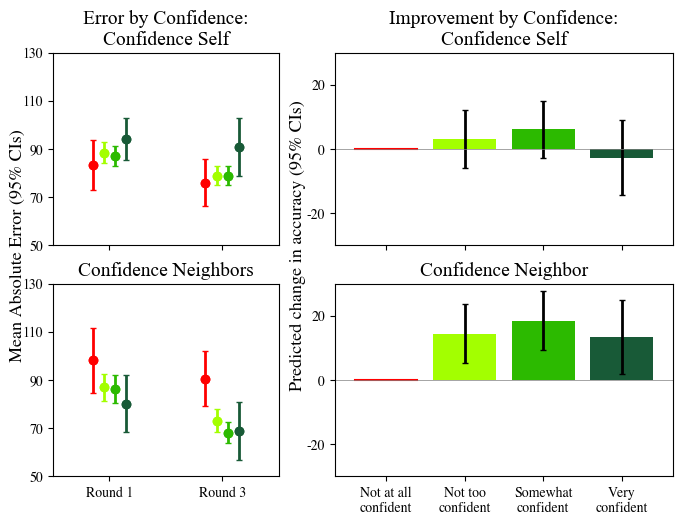

In [8]:
# Plot these results



df['initial_confidence_rank'] = df.initial_confidence.replace({'Not at all confident': 1, 'Not too confident': 2, 'Somewhat confident': 3, 'Very confident': 4})
df['neighbor_confidence_rank'] = df.neighbor_confidence.replace({'Not at all confident': 1, 'Not too confident': 2, 'Somewhat confident': 3, 'Very confident': 4})
df['final_confidence_rank'] = df.final_confidence.replace({'Not at all confident': 1, 'Not too confident': 2, 'Somewhat confident': 3, 'Very confident': 4})

### INITIAL Confidence in Self
df_temp = df.loc[df.Net_type == 'Network']
df_temp = df_temp[['initial_confidence_rank', 'Initial_Error','Final_Error']].dropna()
df_temp = df_temp.loc[df_temp.Initial_Error < 492]
df_temp['initial_confidence_rank'] = df_temp.initial_confidence_rank.astype(int)
df_temp['Initial_Error'] = df_temp.Initial_Error.astype(float)
df_temp['Final_Error'] = df_temp.Final_Error.astype(float)
df_temp['initial_confidence_rank'] = df_temp.initial_confidence_rank.astype(str)
model_1_noc = smf.ols('Final_Error ~ Initial_Error', data=df_temp).fit()
model_1 = smf.ols('Final_Error ~ Initial_Error + initial_confidence_rank', data=df_temp).fit()

# Final Confidence in self
df_temp = df.loc[df.Net_type == 'Network']
df_temp = df_temp[['final_confidence_rank', 'Initial_Error','Final_Error']].dropna()
df_temp = df_temp.loc[df_temp.Initial_Error < 492]
df_temp['final_confidence_rank'] = df_temp.final_confidence_rank.astype(int)
df_temp['Initial_Error'] = df_temp.Initial_Error.astype(float)
df_temp['Final_Error'] = df_temp.Final_Error.astype(float)
df_temp['final_confidence_rank'] = df_temp.final_confidence_rank.astype(str)
model_1_nocb = smf.ols('Final_Error ~ Initial_Error', data=df_temp).fit()
model_1b = smf.ols('Final_Error ~ Initial_Error + final_confidence_rank', data=df_temp).fit()


# Confidence in neighbors
df_temp = df.loc[df.Net_type == 'Network']
df_temp = df_temp[['neighbor_confidence_rank', 'Initial_Error','Final_Error']].dropna()
df_temp = df_temp.loc[df_temp.Initial_Error < 492]
df_temp = df_temp.loc[df_temp.neighbor_confidence_rank != 'None']
df_temp['neighbor_confidence_rank'] = df_temp.neighbor_confidence_rank.astype(int)
df_temp['Initial_Error'] = df_temp.Initial_Error.astype(float)
df_temp['Final_Error'] = df_temp.Final_Error.astype(float)

# Change neighborhood_confidence_rank to a categorical variable
df_temp['neighbor_confidence_rank'] = df_temp.neighbor_confidence_rank.astype(str)
model_2_noc = smf.ols('Final_Error ~ Initial_Error', data=df_temp).fit()
model_2 = smf.ols('Final_Error ~ Initial_Error + neighbor_confidence_rank', data=df_temp).fit()



fig, axs = plt.subplots(2,2,figsize=(8,5.5),gridspec_kw={'width_ratios': [1, 1.5]})

# Confidence in self -------------------------------------------
options = ['Not at all confident', 'Not too confident', 'Somewhat confident', 'Very confident']
colors = ['#ff0000','#a3ff00','#2cba00','#185a37']
df_temp = df.dropna(subset=['initial_confidence'])
df_temp = df_temp.loc[df_temp.response_1 < 492]
df_temp['Accuracy_1'] = abs(df_temp.response_1 - 246)
df_temp['Accuracy_3'] = abs(df_temp.response_3 - 246)

i = 0
for o in options:
    df_t = df_temp.loc[df_temp.initial_confidence == o]
    axs[0,0].plot([0.85+i,1.85+i],[df_t['Accuracy_1'].mean(), df_t['Accuracy_3'].mean()], color=colors[int(i*10)],marker='o',linestyle='None')
    axs[0,0].errorbar([0.85+i,1.85+i],[df_t['Accuracy_1'].mean(), df_t['Accuracy_3'].mean()],
                [1.96 * df_t[i].std()/np.sqrt(df_t[i].count()) for i in ['Accuracy_1', 'Accuracy_3']],
                capsize=2, color=colors[int(i*10)],lw=2, marker='o',linestyle='None')
    i += 0.1

axs[0,0].set_xticks([1,2])
axs[0,0].set_xticklabels(['',''])
axs[0,0].set_xlim(0.5,2.5)
axs[0,0].set_title('Error by Confidence:\nConfidence Self', fontsize = 14, fontname='Times New Roman')
axs[0,0].set_yticks([50,70,90,110,130])
axs[0,0].set_yticklabels([50,70,90,110,130], fontsize = 11, font = 'times')
axs[0,0].set_ylim(50,130)


# Confidence in neighbors -------------------------------------------
options = ['Not at all confident', 'Not too confident', 'Somewhat confident', 'Very confident']
df_temp = df.dropna(subset=['initial_confidence'])
df_temp = df_temp.loc[df_temp.response_1 < 492]
df_temp['Accuracy_1'] = abs(df_temp.response_1 - 246)
df_temp['Accuracy_3'] = abs(df_temp.response_3 - 246)

i = 0
for o in options:
    df_t = df_temp.loc[df_temp.neighbor_confidence == o]
    axs[1,0].plot([0.85+i,1.85+i],[df_t['Accuracy_1'].mean(), df_t['Accuracy_3'].mean()], color=colors[int(i*10)],marker='o',linestyle='None',label='Control')
    axs[1,0].errorbar([0.85+i,1.85+i],[df_t['Accuracy_1'].mean(), df_t['Accuracy_3'].mean()],
                [1.96 * df_t[i].std()/np.sqrt(df_t[i].count()) for i in ['Accuracy_1', 'Accuracy_3']],
                capsize=2, color=colors[int(i*10)],lw=2, marker='o',linestyle='None')
    i += 0.1

axs[1,0].set_xticks([1,2])
axs[1,0].set_xticklabels(['Round 1', 'Round 3'], fontsize = 12, font='times')
axs[1,0].set_ylabel('Mean Absolute Error (95% CIs)', fontsize = 13, font = 'times')
axs[1,0].set_yticks([50,70,90,110,130])
axs[1,0].set_yticklabels([50,70,90,110,130], fontsize = 11, font = 'times')
axs[1,0].yaxis.set_label_coords(-0.12,1.2)
axs[1,0].set_xlim(0.5,2.5)
axs[1,0].set_title('Confidence Neighbors', fontsize = 14, fontname='Times New Roman')
axs[1,0].set_ylim(50,130)



# Create a bar plot of the change in accuracy for each confidence level
i = 1
for o in options[:-1]:
    axs[0,1].bar([0+i],[-model_1.params[i]], color=colors[i],label='Control')
    axs[0,1].errorbar([0+i],[-model_1.params[i]],
                [1.96 * model_1.bse[i]],
                capsize=2, color='black',lw=2)
    i += 1
axs[0,1].set_xticks([0,1,2,3])
axs[0,1].plot([-.4,.4],[0,0],'-',color=colors[0])
axs[0,1].set_xticklabels(["","","",""])
axs[0,1].set_title('Improvement by Confidence:\nConfidence Self', fontsize = 14,  fontname='Times New Roman')
axs[0,1].set_yticks([-40,-20,0, 20,40])
axs[0,1].set_yticklabels([-40,-20,0, 20,40],fontsize=11, font='times')
axs[0,1].set_ylim(-30,30)
axs[0,1].plot([-1,5],[0,0],'-',color='gray',lw=0.5)
axs[0,1].set_xlim(-.65,3.65)

# Confidence in neighbors -------------------------------------------
options = ['Not at all\nconfident', 'Not too\nconfident', 'Somewhat\nconfident', 'Very\nconfident']

i = 1
for o in options[:-1]:
    axs[1,1].bar([0+i],[-model_2.params[i]], color=colors[i],label='Control')
    axs[1,1].errorbar([0+i],[-model_2.params[i]],
                [1.96 * model_2.bse[i]],
                capsize=2, color='black',lw=2)
    i += 1
axs[1,1].set_xticks([0,1,2,3])
axs[1,1].set_yticks([-40,-20,0, 20,40])
axs[1,1].plot()
axs[1,1].set_yticklabels([-40,-20,0, 20,40],fontsize=11, font = 'times')
axs[1,1].plot([-.4,.4],[0,0],'-',color=colors[0])
axs[1,1].set_xticklabels(options, fontsize = 12, font = 'times')
axs[1,1].set_ylabel('Predicted change in accuracy (95% CIs)', fontsize = 13, font='times')
axs[1,1].yaxis.set_label_coords(-0.085,1.2)
axs[1,1].plot([-1,5],[0,0],'-',color='gray',lw=0.5)
axs[1,1].set_xlim(-.65,3.65)
axs[1,1].set_title('Confidence Neighbor', fontsize = 14, fontname='Times New Roman')
axs[1,1].set_ylim(-30,30)

#plt.tight_layout()
plt.savefig('Figures/Figure-4_Confidence.png', dpi=300)
plt.show()


In [10]:
# Updated crowd level results with table
df = pd.read_csv('ci_cb_2023-06-26.csv')

df['Anchor'] = np.where(df['Condition'] == 'Low', 118, 353)
df['Mag_Rev1'] = abs(df['response_2'] - df['response_1'])
df['Mag_Rev2'] = abs(df['response_3'] - df['response_2'])
df['Mag_Rev'] = abs(df['response_3'] - df['response_1'])
df['Initial_Error'] = abs(df['response_1'] - df['true_answer'])
df['Second_Error'] = abs(df['response_2'] - df['true_answer'])
df['Final_Error'] = abs(df['response_3'] - df['true_answer'])
df['Dist_Anchor_1'] = abs(df['response_1'] - df['Anchor'])
df['Dist_Anchor_2'] = abs(df['response_2'] - df['Anchor'])
df['Dist_Anchor_3'] = abs(df['response_3'] - df['Anchor'])
df['Difference_Initial_Anchor'] = df['response_1'] - df['Anchor']
df['Difference_Initial_Truth'] = df['response_1'] - 246
df['Matched'] = np.where(df['Difference_Initial_Anchor'] * df['Difference_Initial_Truth'] > 0, 1, 0)
df['Change_accuracy'] = df['Initial_Error'] - df['Final_Error']


df_temp = df.loc[df.Net_type == 'Network']
df_temp = df_temp.groupby('group').agg({'response_1': np.median,  'response_2': np.median, 'response_3': np.median, 'Anchor': 'first', 'Condition': 'first'})

# Calculate the difference between response 1/3 and anchor and how it changes across rounds
df_temp['Dif_1'] = abs(df_temp.response_1 - df_temp.Anchor)
df_temp['Dif_3'] = abs(df_temp.response_3 - df_temp.Anchor)
df_temp['Change'] =  df_temp['Dif_3'] - df_temp['Dif_1']

df_temp['Error_1'] = abs(df_temp.response_1 - 246)
df_temp['Error_2'] = abs(df_temp.response_2 - 246)
df_temp['Error_3'] = abs(df_temp.response_3 - 246)
df_temp['Change_Error'] = df_temp['Error_3'] - df_temp['Error_1']


# Group by whether the anchor is in the direction of truth (Matched == 1) or not (Matched == 0)
df_temp['Difference_Initial_Anchor'] = df_temp['response_1'] - df_temp['Anchor']
df_temp['Difference_Initial_Truth'] = df_temp['response_1'] - 246
df_temp['Matched'] = np.where(df_temp['Difference_Initial_Anchor'] * df_temp['Difference_Initial_Truth'] > 0, 1, 0)
df_network = df_temp.copy()
df_t_n = df_temp.loc[df_temp.Matched == 1].dropna(subset=['Dif_1', 'Dif_3'])
df_f_n = df_temp.loc[df_temp.Matched == 0].dropna(subset=['Dif_1', 'Dif_3'])

print('\n\nProximity to anchor networks')
print('Helpful Change: ',df_t_n['Change'].mean())
print(stats.wilcoxon(df_t_n.Change, method='approx',correction=False))
print('Harmful Change: ',df_f_n['Change'].mean())
print(stats.wilcoxon(df_f_n.Change, method='approx',correction=False))



# Control Group Level
df_temp = df.loc[df.Net_type == 'Control']
df_temp = df_temp.groupby('group').agg({'response_1': np.median, 'response_2': np.median, 'response_3': np.median, 'Anchor': np.median})
df_temp = df_temp.loc[~df_temp.index.isin([18])]

# Calculate the difference between response 1/3 and anchor  and how it changes across rounds
df_temp['Dif_1'] = abs(df_temp.response_1 - df_temp.Anchor)
df_temp['Dif_3'] = abs(df_temp.response_3 - df_temp.Anchor)
df_temp['Change'] =  df_temp['Dif_3'] - df_temp['Dif_1']

df_temp['Error_1'] = abs(df_temp.response_1 - 246)
df_temp['Error_2'] = abs(df_temp.response_2 - 246)
df_temp['Error_3'] = abs(df_temp.response_3 - 246)
df_temp['Change_Error'] = df_temp['Error_3'] - df_temp['Error_1']

# Group by whether the anchor is in the direction of truth (Matched == 1) or not (Matched == 0)
df_temp['Difference_Initial_Anchor'] = df_temp['response_1'] - df_temp['Anchor']
df_temp['Difference_Initial_Truth'] = df_temp['response_1'] - 246
df_temp['Matched'] = np.where(df_temp['Difference_Initial_Anchor'] * df_temp['Difference_Initial_Truth'] > 0, 1, 0)
df_control = df_temp.copy()
df_t_c = df_temp.loc[df_temp.Matched == 1].dropna(subset=['Dif_1', 'Dif_3'])
df_f_c = df_temp.loc[df_temp.Matched == 0].dropna(subset=['Dif_1', 'Dif_3'])

print('Controls')
print('Helpful Change: ',df_t_c['Change'].mean())
print(stats.wilcoxon(df_t_c.Change, method='approx',correction=False))
print('Harmful Change: ',df_f_c['Change'].mean())
print(stats.wilcoxon(df_f_c.Change, method='approx',correction=False))

print('Compare Change')
print('Helpful:',stats.mannwhitneyu(df_t_c.Change, df_t_n.Change))
print('Harmful',stats.mannwhitneyu(df_f_c.Change, df_f_n.Change))

print("Overall")
print("Networks")
print(df_network.groupby('Matched')[['Error_1','Error_2','Error_3','Change_Error','Change']].mean())
print("Improvement:", df_network['Change_Error'].mean(), stats.wilcoxon(df_network['Change_Error'], method='approx',correction=False))
print("Controls")
print(df_control.groupby('Matched')[['Error_1','Error_2','Error_3','Change_Error','Change']].mean())
print("Improvement:", df_control['Change_Error'].mean(), stats.wilcoxon(df_control['Change_Error'], method='approx',correction=False))
print('Compare Improvement:', stats.mannwhitneyu(df_network['Change_Error'], df_control['Change_Error']))





Proximity to anchor networks
Helpful Change:  -7.722222222222222
WilcoxonResult(statistic=6.5, pvalue=0.057804009593183575)
Harmful Change:  11.136363636363637
WilcoxonResult(statistic=0.0, pvalue=0.005005074402905221)
Controls
Helpful Change:  -1.0
WilcoxonResult(statistic=16.0, pvalue=0.779434528427275)
Harmful Change:  3.5454545454545454
WilcoxonResult(statistic=11.0, pvalue=0.05023302822033749)
Compare Change
Helpful: MannwhitneyuResult(statistic=48.0, pvalue=0.2765939942410531)
Harmful MannwhitneyuResult(statistic=22.0, pvalue=0.012287879359720744)
Overall
Networks
           Error_1    Error_2    Error_3  Change_Error     Change
Matched                                                          
0        97.227273  87.500000  86.545455    -10.681818  11.136364
1        38.833333  35.277778  31.111111     -7.722222  -7.722222
Improvement: -9.35 WilcoxonResult(statistic=8.5, pvalue=0.0004930992620375222)
Controls
           Error_1    Error_2    Error_3  Change_Error    Change
Matc

/var/folders/xp/jv15pxc52y1dwz_14_0kyy740000gp/T/ipykernel_63437/874982952.py:21: FutureWarning: The provided callable <function median at 0x10d4d4ae0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  df_temp = df_temp.groupby('group').agg({'response_1': np.median,  'response_2': np.median, 'response_3': np.median, 'Anchor': 'first', 'Condition': 'first'})
/Users/calvinisch/anaconda3/envs/new_project/lib/python3.11/site-packages/scipy/stats/_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)
/var/folders/xp/jv15pxc52y1dwz_14_0kyy740000gp/T/ipykernel_63437/874982952.py:52: FutureWarning: The provided callable <function median at 0x10d4d4ae0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly